This notebook aims to save a CSV with the beta values of the CpG sites most significantly associated with age so that I can use these 50 sites as input variables in my models. 

First, I need to create a list of the sites that I identified as significantly associated with age in the find_significant_sites.ipynb.

In [1]:
#import packages
from pathlib import Path
from mepylome import MethylData
import pandas as pd
import csv
import numpy as np

In [2]:
# Path to analysis directory
analysis_dir = Path("../../7309")

# Read SDRF file into dataframe
df = pd.read_csv(analysis_dir / "Characteristics.csv")

# sort df according to patient and  age
df['ID']=df['Individual'].str.extract(r'IND_(\d+)').astype(int)
df.sort_values(by=['ID', 'Age'],inplace=True)

df.head(10)

,Array_data_file,Sample,Individual,Age,Sex,Twin_pair,ID
1008,9741950045_R03C02,Sample_305,IND_1,89.901370,female,TP_1,1
217,9721365024_R06C02,Sample_635,IND_2,94.000000,female,TP_2,2
635,9721365100_R01C01,Sample_531,IND_3,97.879450,female,TP_3,3
946,9741950003_R05C01,Sample_257,IND_4,66.530134,female,TP_4,4
182,9721365017_R06C01,Sample_778,IND_4,73.568486,female,TP_4,4
417,9721365055_R03C02,Sample_357,IND_4,82.403833,female,TP_4,4
311,9721365040_R02C01,Sample_796,IND_4,84.528405,female,TP_4,4
1036,9741950062_R06C02,Sample_330,IND_5,66.530134,female,TP_4,5
205,9721365023_R06C02,Sample_794,IND_5,73.852509,female,TP_4,5
644,9721365100_R05C02,Sample_541,IND_5,82.403833,female,TP_4,5


In [3]:
df.shape

(1072, 7)

In [4]:
# now will read only significant sites
significant_sites=pd.read_csv("significant_sites.csv")
display(significant_sites)

,Site,Adj_P_Value
0,cg16867657,9.842221e-15
1,cg22454769,2.947556e-09
2,cg07082267,6.013528e-09
3,cg10917602,1.105203e-08
4,cg23744638,3.714922e-08
5,cg26153045,3.946568e-08
6,cg02085953,5.057521e-08
7,cg07927379,5.147603e-08
8,cg12554573,5.934285e-08
9,cg19216211,1.882707e-07


In [5]:
#convert to list to extract only these columns
columns=['ID','Age']+significant_sites['Site'].tolist()
print(columns)

['ID', 'Age', 'cg16867657', 'cg22454769', 'cg07082267', 'cg10917602', 'cg23744638', 'cg26153045', 'cg02085953', 'cg07927379', 'cg12554573', 'cg19216211', 'cg05194346', 'cg01594949', 'cg23500537', 'cg16932827', 'cg06911110', 'cg14977938', 'cg06639320', 'cg01557754', 'cg00755588', 'cg12492496', 'cg07127410', 'cg23634177', 'cg26211349', 'cg23718736', 'cg01054110', 'cg00636737', 'cg23078123', 'cg20010135', 'cg07553761', 'cg17183905', 'cg08426733', 'cg25793051', 'cg09809672', 'cg19784428', 'cg21874213', 'cg03211593', 'cg24724428', 'cg10501210', 'cg01190666', 'cg15626285', 'cg00292135', 'cg11693709', 'cg23737927', 'cg16624521', 'cg25994988', 'cg06761850', 'cg02315732', 'cg20732076', 'cg04608933', 'cg11436767']


Next, I will parse the IDAT files of all individuals, preprocess and normalise them and extract the beta values.

In [6]:
import pandas as pd

def read_single_id(df, specific_id, sites):
    combined_data = []

    # Filter the DataFrame for the specific ID
    df_filtered = df[df['ID'] == specific_id]

    # Iterate over each row in the filtered DataFrame
    for _, row in df_filtered.iterrows():
        file_path = analysis_dir / row['Array_data_file']
        data = MethylData(file=file_path).betas.T
        data['ID'] = row['ID']
        data['Age'] = row['Age']
        combined_data.append(data)

    # Concatenate all data into a single DataFrame
    combined_df = pd.concat(combined_data, ignore_index=True)
    combined_df = combined_df[sites]
    combined_df = combined_df[['ID', 'Age'] + [col for col in combined_df.columns if col not in ['ID', 'Age']]]

    return combined_df


In [7]:
new=read_single_id(df, 4, columns)

In [8]:
new

,ID,Age,cg16867657,cg22454769,cg07082267,cg10917602,cg23744638,cg26153045,cg02085953,cg07927379,...,cg00292135,cg11693709,cg23737927,cg16624521,cg25994988,cg06761850,cg02315732,cg20732076,cg04608933,cg11436767
0,4,66.530134,0.646309,0.486484,0.380866,0.583188,0.569642,0.375602,0.354024,0.042392,...,0.114310,0.417675,0.759947,0.681296,0.474299,0.296988,0.560873,0.190937,0.675305,0.406668
1,4,73.568486,0.799299,0.495504,0.357534,0.543829,0.527590,0.311308,0.308736,0.043762,...,0.107074,0.411936,0.833769,0.659152,0.384782,0.281054,0.561824,0.155627,0.655442,0.400266
2,4,82.403833,0.737156,0.547054,0.414491,0.577654,0.553128,0.342647,0.267324,0.160710,...,0.150684,0.392358,0.639692,0.683428,0.451075,0.311980,0.428577,0.153598,0.706284,0.374923
3,4,84.528405,0.837627,0.559392,0.355323,0.525814,0.521606,0.253690,0.271183,0.079572,...,0.089873,0.393527,0.699139,0.644453,0.331450,0.325187,0.373445,0.112596,0.678522,0.353805


In [9]:
def read_multiple_ids(df, id_list, sites):
    total_combined_data = []

    for specific_id in id_list:
        combined_df = read_single_id(df, specific_id, sites)
        total_combined_data.append(combined_df)

    total_combined_df = pd.concat(total_combined_data, ignore_index=True)
    return total_combined_df

new=read_multiple_ids(df,[4,5], columns)
new.head(10)

,ID,Age,cg16867657,cg22454769,cg07082267,cg10917602,cg23744638,cg26153045,cg02085953,cg07927379,...,cg00292135,cg11693709,cg23737927,cg16624521,cg25994988,cg06761850,cg02315732,cg20732076,cg04608933,cg11436767
0,4,66.530134,0.646309,0.486484,0.380866,0.583188,0.569642,0.375602,0.354024,0.042392,...,0.114310,0.417675,0.759947,0.681296,0.474299,0.296988,0.560873,0.190937,0.675305,0.406668
1,4,73.568486,0.799299,0.495504,0.357534,0.543829,0.527590,0.311308,0.308736,0.043762,...,0.107074,0.411936,0.833769,0.659152,0.384782,0.281054,0.561824,0.155627,0.655442,0.400266
2,4,82.403833,0.737156,0.547054,0.414491,0.577654,0.553128,0.342647,0.267324,0.160710,...,0.150684,0.392358,0.639692,0.683428,0.451075,0.311980,0.428577,0.153598,0.706284,0.374923
3,4,84.528405,0.837627,0.559392,0.355323,0.525814,0.521606,0.253690,0.271183,0.079572,...,0.089873,0.393527,0.699139,0.644453,0.331450,0.325187,0.373445,0.112596,0.678522,0.353805
4,5,66.530134,0.702288,0.526904,0.361381,0.543922,0.672069,0.348870,0.322995,0.105713,...,0.141782,0.382297,0.741858,0.559220,0.405146,0.290188,0.452989,0.120012,0.625062,0.417433
5,5,73.852509,0.820860,0.577691,0.373576,0.498148,0.614670,0.316506,0.343476,0.077343,...,0.178324,0.347342,0.727501,0.505839,0.344634,0.308590,0.524471,0.104955,0.599907,0.342823
6,5,82.403833,0.838836,0.572076,0.304438,0.486565,0.655282,0.244592,0.348290,0.133586,...,0.159521,0.314774,0.627057,0.513647,0.366603,0.238929,0.452037,0.105946,0.573729,0.392948
7,5,84.531143,0.840359,0.596924,0.263943,0.493135,0.623089,0.301661,0.289652,0.175717,...,0.189232,0.281201,0.625621,0.495396,0.306589,0.238906,0.361037,0.113026,0.575963,0.334129


In [10]:
#create list of unique ids
import numpy as np

IDs=np.unique(df['ID'])

new=read_multiple_ids(df,IDs, columns) # read all patients only significant sites
print(new.shape)
new.head(10)

(1072, 52)


,ID,Age,cg16867657,cg22454769,cg07082267,cg10917602,cg23744638,cg26153045,cg02085953,cg07927379,...,cg00292135,cg11693709,cg23737927,cg16624521,cg25994988,cg06761850,cg02315732,cg20732076,cg04608933,cg11436767
0,1,89.901370,0.702134,0.617247,0.309282,0.480625,0.556098,0.321821,0.314697,0.073288,...,0.114535,0.256534,0.586134,0.656403,0.411849,0.292660,0.398222,0.105039,0.653653,0.373123
1,2,94.000000,0.729290,0.731379,0.213783,0.449248,0.494431,0.324626,0.296414,0.018520,...,0.174267,0.231969,0.604058,0.568733,0.336492,0.339834,0.321057,0.041996,0.619470,0.282783
2,3,97.879450,0.688162,0.681539,0.342350,0.498799,0.566515,0.213102,0.275044,0.040328,...,0.134725,0.198174,0.612303,0.565486,0.348359,0.183476,0.414816,0.065445,0.648604,0.316858
3,4,66.530134,0.646309,0.486484,0.380866,0.583188,0.569642,0.375602,0.354024,0.042392,...,0.114310,0.417675,0.759947,0.681296,0.474299,0.296988,0.560873,0.190937,0.675305,0.406668
4,4,73.568486,0.799299,0.495504,0.357534,0.543829,0.527590,0.311308,0.308736,0.043762,...,0.107074,0.411936,0.833769,0.659152,0.384782,0.281054,0.561824,0.155627,0.655442,0.400266
5,4,82.403833,0.737156,0.547054,0.414491,0.577654,0.553128,0.342647,0.267324,0.160710,...,0.150684,0.392358,0.639692,0.683428,0.451075,0.311980,0.428577,0.153598,0.706284,0.374923
6,4,84.528405,0.837627,0.559392,0.355323,0.525814,0.521606,0.253690,0.271183,0.079572,...,0.089873,0.393527,0.699139,0.644453,0.331450,0.325187,0.373445,0.112596,0.678522,0.353805
7,5,66.530134,0.702288,0.526904,0.361381,0.543922,0.672069,0.348870,0.322995,0.105713,...,0.141782,0.382297,0.741858,0.559220,0.405146,0.290188,0.452989,0.120012,0.625062,0.417433
8,5,73.852509,0.820860,0.577691,0.373576,0.498148,0.614670,0.316506,0.343476,0.077343,...,0.178324,0.347342,0.727501,0.505839,0.344634,0.308590,0.524471,0.104955,0.599907,0.342823
9,5,82.403833,0.838836,0.572076,0.304438,0.486565,0.655282,0.244592,0.348290,0.133586,...,0.159521,0.314774,0.627057,0.513647,0.366603,0.238929,0.452037,0.105946,0.573729,0.392948


The new dataframe contains the beta values for all the top 50 sites significantly associated with age across the samples for all individuals. The dataframe is ordered by the ID of each individual and their samples are in ascending order. Again, I need to fill in the missing values with the mean for that CpG site. 

In [11]:
# filling NaN  with mean
new.fillna(new.mean(), inplace=True)
new

,ID,Age,cg16867657,cg22454769,cg07082267,cg10917602,cg23744638,cg26153045,cg02085953,cg07927379,...,cg00292135,cg11693709,cg23737927,cg16624521,cg25994988,cg06761850,cg02315732,cg20732076,cg04608933,cg11436767
0,1,89.901370,0.702134,0.617247,0.309282,0.480625,0.556098,0.321821,0.314697,0.073288,...,0.114535,0.256534,0.586134,0.656403,0.411849,0.292660,0.398222,0.105039,0.653653,0.373123
1,2,94.000000,0.729290,0.731379,0.213783,0.449248,0.494431,0.324626,0.296414,0.018520,...,0.174267,0.231969,0.604058,0.568733,0.336492,0.339834,0.321057,0.041996,0.619470,0.282783
2,3,97.879450,0.688162,0.681539,0.342350,0.498799,0.566515,0.213102,0.275044,0.040328,...,0.134725,0.198174,0.612303,0.565486,0.348359,0.183476,0.414816,0.065445,0.648604,0.316858
3,4,66.530134,0.646309,0.486484,0.380866,0.583188,0.569642,0.375602,0.354024,0.042392,...,0.114310,0.417675,0.759947,0.681296,0.474299,0.296988,0.560873,0.190937,0.675305,0.406668
4,4,73.568486,0.799299,0.495504,0.357534,0.543829,0.527590,0.311308,0.308736,0.043762,...,0.107074,0.411936,0.833769,0.659152,0.384782,0.281054,0.561824,0.155627,0.655442,0.400266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067,443,63.279945,0.611937,0.482561,0.368911,0.527637,0.597208,0.320079,0.365124,0.018291,...,0.044535,0.383536,0.588711,0.672096,0.367295,0.257173,0.473222,0.109472,0.642624,0.375736
1068,444,53.083333,0.586583,0.506666,0.391517,0.494777,0.622710,0.340618,0.329488,0.031451,...,0.024298,0.334620,0.643446,0.622908,0.429471,0.255971,0.378320,0.082834,0.631398,0.336461
1069,444,56.449008,0.610684,0.504960,0.341092,0.537334,0.661538,0.322985,0.321921,0.023200,...,0.045750,0.347742,0.606948,0.645747,0.372052,0.259447,0.485303,0.072514,0.669993,0.386152
1070,444,61.034908,0.656474,0.533427,0.325426,0.543267,0.554451,0.316660,0.320079,0.050637,...,0.144694,0.394705,0.671875,0.659016,0.404502,0.255755,0.410657,0.105614,0.659271,0.433721


In [12]:
individuals = pd.DataFrame(new.groupby('ID').size())
individuals.shape

(444, 1)

Here, I confirmed that there are samples from 444 particpants. 

In [15]:
count_per_id = df.groupby('ID').size()
num_ids_with_gt5 = (count_per_id > 2).sum()
num_ids_with_gt5

np.int64(201)

201 twins have 3 or more samples 

In [14]:
new['Age'].mean()

np.float64(73.0833568367071)

The average age is 73 years. 

Next, I will conduct PCA to identify any outlier samples so I can remove them from the analytical sample. Labelling the rows in the PCA plot allows me to determine which samples need to be removed. 

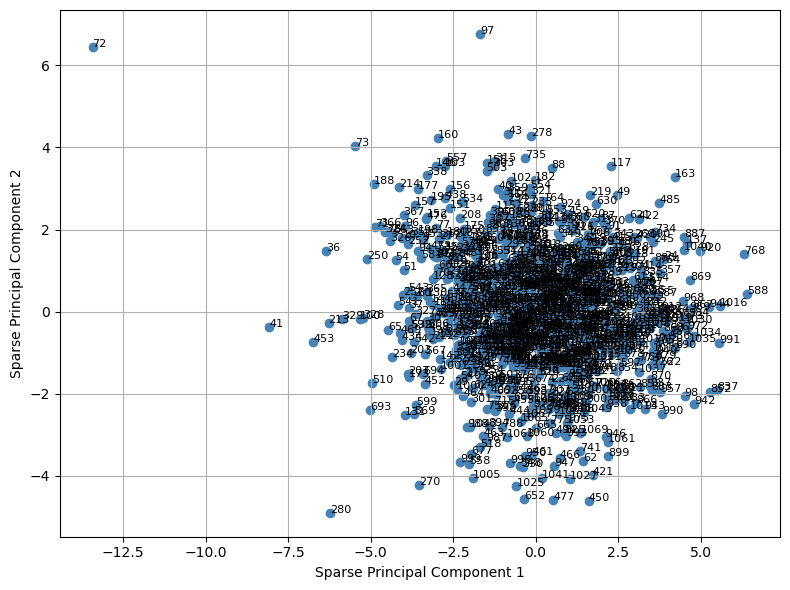

In [15]:
from sklearn.decomposition import SparsePCA
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import SparsePCA
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('scaling', StandardScaler()), ('spca', SparsePCA(n_components=5))])

X_spca = pipeline.fit_transform(new.iloc[:, 2:])

pca_columns = ['SPCA1', 'SPCA2', 'SPCA3', 'SPCA4', 'SPCA5']
pca_results = pd.DataFrame(X_spca, columns=pca_columns, index=new.index)
pca_results['ID'] = new.iloc[:, 0].values
pca_results['Age'] = new['Age']

plt.figure(figsize=(8, 6))
plt.scatter(pca_results['SPCA1'], pca_results['SPCA2'], color='steelblue')

for idx, row in pca_results.iterrows():
    plt.text(row['SPCA1'], row['SPCA2'], str(idx), fontsize=8)

plt.xlabel('Sparse Principal Component 1')
plt.ylabel('Sparse Principal Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

Sample 72 and 97 appear to be outliers so I will remove them from the analytical sample.

In [16]:
# remove samples because of outlier 
new = new.drop([72, 97])
new.shape

(1070, 52)

In [17]:
individuals = pd.DataFrame(new.groupby('ID').size())
individuals.shape

(443, 1)

There are now 443 twins in the analytical sample. 

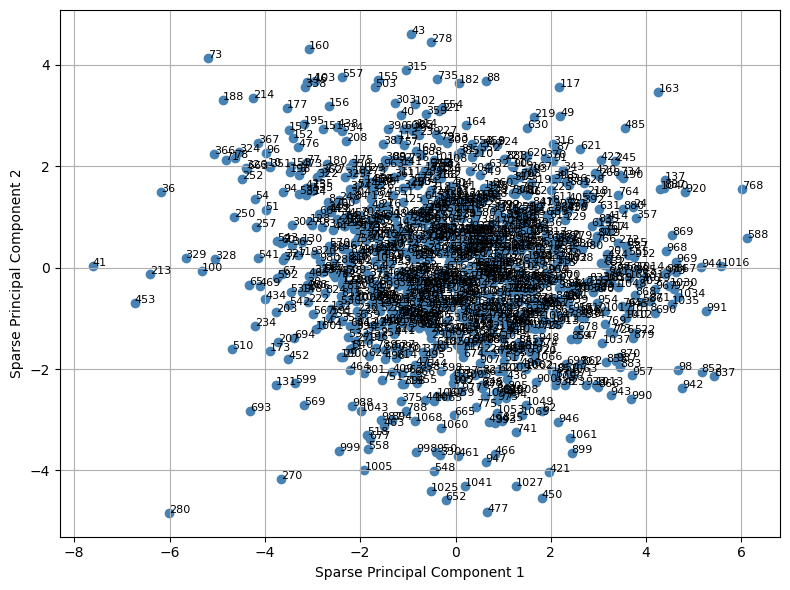

In [18]:
pipeline = Pipeline([('scaling', StandardScaler()), ('spca', SparsePCA(n_components=5))])

X_spca = pipeline.fit_transform(new.iloc[:, 2:])

pca_columns = ['SPCA1', 'SPCA2', 'SPCA3', 'SPCA4', 'SPCA5']
pca_results = pd.DataFrame(X_spca, columns=pca_columns, index=new.index)
pca_results['ID'] = new.iloc[:, 0].values
pca_results['Age'] = new['Age']

plt.figure(figsize=(8, 6))
plt.scatter(pca_results['SPCA1'], pca_results['SPCA2'], color='steelblue')

for idx, row in pca_results.iterrows():
    plt.text(row['SPCA1'], row['SPCA2'], str(idx), fontsize=8)

plt.xlabel('Sparse Principal Component 1')
plt.ylabel('Sparse Principal Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

Repeating sparse PCA demonstrates that more consistent clustering of the data points.

In [34]:
#saving significant betas for future use
new.to_csv("significant_betas.csv", index=False)

significant_betas.csv now contains the beta values of the CpG sites most significantly associated with age so that I can use these 50 sites as input variables in my models. 

Histogram to show the distribution of ages:

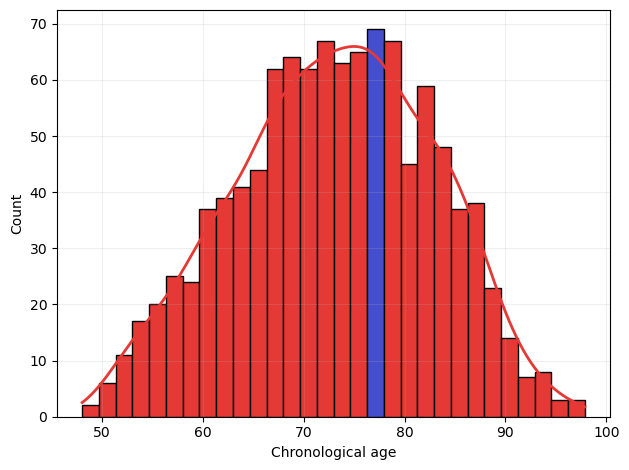

In [29]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Data
data = new['Age']

# Plot histogram
counts, bins, patches = plt.hist(data, bins=30, edgecolor='k')

kde = gaussian_kde(data)
x_vals = np.linspace(data.min(), data.max(), 1000)
density = kde(x_vals)

# Scale KDE to match histogram height
bin_width = bins[1] - bins[0]
scaled_density = density * len(data) * bin_width  # Scale to match count units

# Plot KDE line
plt.plot(x_vals, scaled_density, color='#E53935', linewidth=2)

max_count = np.max(counts)
max_indices = np.where(counts == max_count)[0]
for i, patch in enumerate(patches):
    if i in max_indices:
        patch.set_facecolor('#454ecd')
    else:
        patch.set_facecolor('#E53935')

# Labels and title
plt.xlabel('Chronological age')
plt.ylabel('Count')
plt.tight_layout()
plt.grid(alpha=0.2)
#plt.show()
plt.savefig("Age distribution (methylation).svg", format='svg', dpi=1200)

Scatter plot to demonstrate how the age of the participants at enrolment, the number of samples taken from each individual and the duration of their follow-up varies:

In [24]:
visits = new

visits['Visit'] = visits.groupby('ID').cumcount() + 1

first_visit_age = visits[visits['Visit'] == 1].sort_values('Age')
order = first_visit_age['ID'].tolist()
visits['ID'] = pd.Categorical(visits['ID'], categories=order, ordered=True)
visits = visits.sort_values(['ID', 'Visit'])

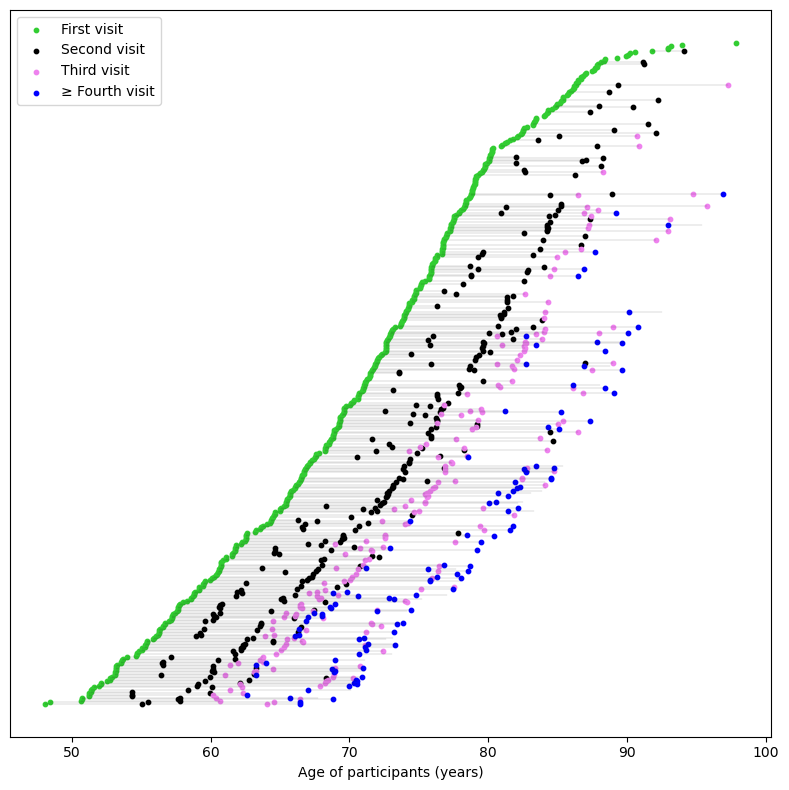

In [25]:
# Visit colors and markers
visit_styles = {
    1: {'color': 'limegreen', 'marker': 'o', 'label': 'First visit'},
    2: {'color': 'black', 'marker': 'o', 'label': 'Second visit'},
    3: {'color': 'violet', 'marker': 'o', 'label': 'Third visit'},
    4: {'color': 'blue', 'marker': 'o', 'label': '≥ Fourth visit'}
}

# Plot visits
plt.figure(figsize=(8, 8))
for visit_num, style in visit_styles.items():
    subset = visits[visits['Visit'] == visit_num]
    plt.scatter(
        subset['Age'], subset['ID'].cat.codes,
        c=style['color'], marker=style['marker'], s=10,
        label=style['label']
    )

for pid, group in visits.groupby('ID'):
    plt.plot(
        group['Age'], group['ID'].cat.codes, color='black', linewidth=0.2, alpha=0.5
    )

plt.xlabel("Age of participants (years)")
plt.gca().yaxis.set_visible(False)
plt.legend()
plt.tight_layout()
plt.show()